# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
from zipfile import ZipFile
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

2025-07-20 01:27:14.345341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752974834.367245    8651 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752974834.373961    8651 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load The Dataset

In [2]:
path = "/kaggle/input/aerial-cactus-identification/"
train_labels = pd.read_csv(path + 'train.csv')
train_labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
class_names = ["Has cactus", "Hasn\'t cactus"]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

class_names_label

{'Has cactus': 0, "Hasn't cactus": 1}

In [4]:
with ZipFile(path + "train.zip") as zipper:
    zipper.extractall()

with ZipFile(path + "test.zip") as zipper:
    zipper.extractall()

In [5]:
train_path = '/kaggle/working/train'
test_path = '/kaggle/working/test'

In [6]:
def load_data(train_labels, train_path):
    x_train = []
    y_train = []

    for idx in range(len(train_labels)):
        img_path = os.path.join(train_path, train_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = train_labels.iloc[idx, 1]

        x_train.append(image)
        y_train.append(label)

    return x_train, y_train

In [7]:
x_train, y_train = load_data(train_labels, train_path)

# Visualize The Dataset

In [8]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

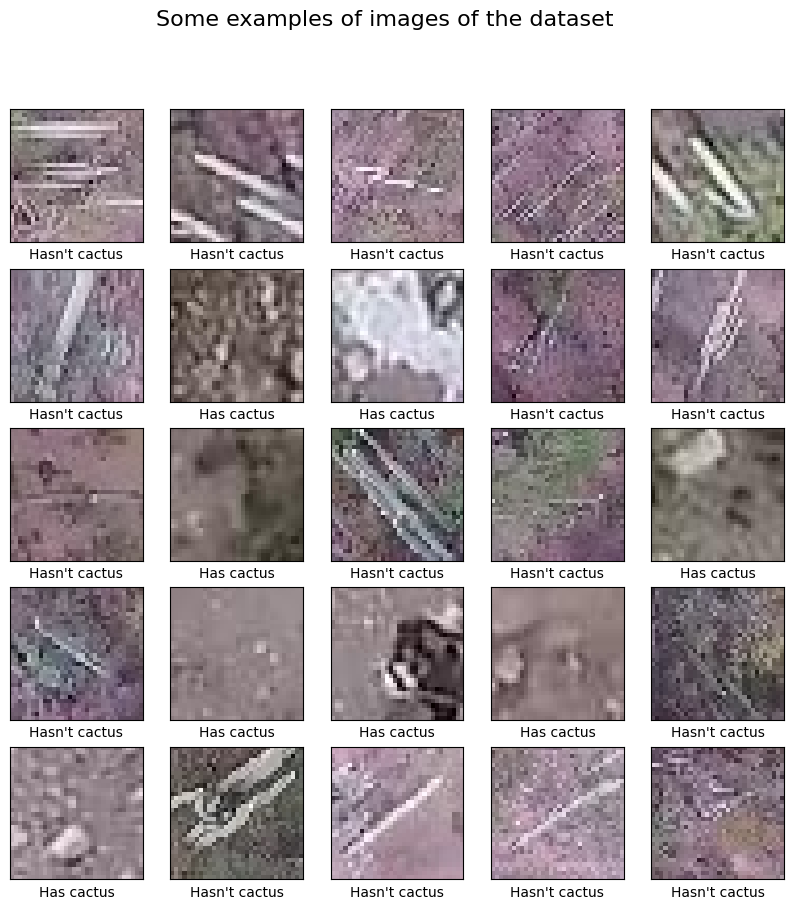

In [9]:
display_examples(class_names, x_train, y_train)

# Imbalabce Data

In [10]:
unique_labels, train_counts = np.unique(y_train, return_counts=True)
print(f"{unique_labels[0]}: {train_counts[0]}\n{unique_labels[1]}: {train_counts[1]}")

0: 4364
1: 13136


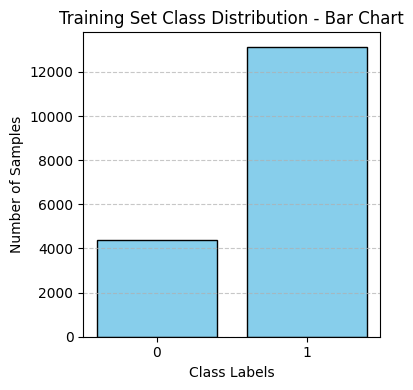

In [11]:
# Bar Plot
plt.figure(figsize=(4, 4))
plt.bar(unique_labels, train_counts, color='skyblue', edgecolor='black')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.title('Training Set Class Distribution - Bar Chart')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


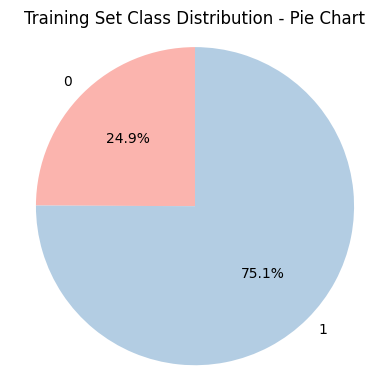

In [12]:
# Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(train_counts, labels=unique_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Training Set Class Distribution - Pie Chart')
plt.axis('equal') 
plt.tight_layout()
plt.show()

# Train/Validation Split

In [13]:
x_train = np.array(x_train, dtype = 'float32')
y_train = np.array(y_train, dtype = 'int32')

In [14]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [15]:
n_train = len(x_train)
n_val = len(x_val)

print ("Number of training examples:",n_train)
print ("Number of validation examples:",n_val)

Number of training examples: 14000
Number of validation examples: 3500


# CNN Model

In [16]:
model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),

    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),

    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752974845.246363    8651 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752974845.246968    8651 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       991,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,085,505 (4.14 MB)

 Trainable params: 1,085,057 (4.14 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.005156115726153, 1: 0.6660957274716909}

In [21]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights
)

Epoch 1/30


I0000 00:00:1752974850.142268    8703 service.cc:148] XLA service 0x7e0298010f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752974850.142303    8703 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752974850.142310    8703 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752974850.497950    8703 cuda_dnn.cc:529] Loaded cuDNN version 90300


 45/438 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7783 - loss: 0.7593

I0000 00:00:1752974852.693441    8703 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8964 - loss: 0.3534 - val_accuracy: 0.7506 - val_loss: 1.9698 - learning_rate: 0.0010
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9287 - loss: 0.1904 - val_accuracy: 0.5640 - val_loss: 1.2347 - learning_rate: 0.0010
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9650 - loss: 0.0875 - val_accuracy: 0.8803 - val_loss: 1.2436 - learning_rate: 0.0010
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9717 - loss: 0.0747 - val_accuracy: 0.9169 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9804 - loss: 0.0500 - val_accuracy: 0.7506 - val_loss: 15.2613 - learning_rate: 0.0010
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9854 - loss: 0.0351 - val_accuracy: 0.9269 - val_loss: 0.3204 - learning_rate: 0.0010
Epoch 7/30
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0388
Epoch 7: R

# Model Evaluation

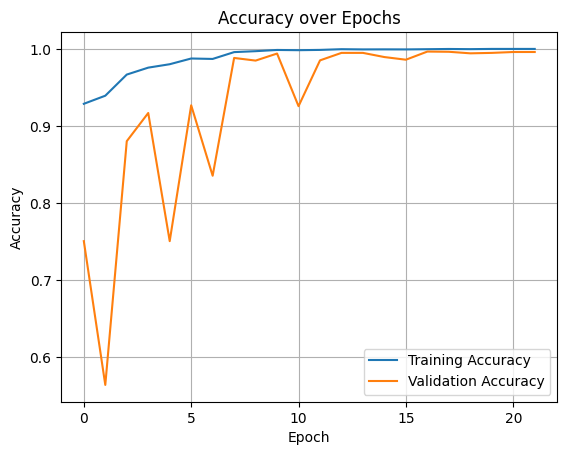

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid()
plt.show()

In [23]:
preds = model.predict(x_val)
preds_labels = (preds > 0.5).astype(int).flatten()
print(classification_report(y_val, preds_labels, digits=4))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0     0.9920    0.9943    0.9931       873
           1     0.9981    0.9973    0.9977      2627

    accuracy                         0.9966      3500
   macro avg     0.9950    0.9958    0.9954      3500
weighted avg     0.9966    0.9966    0.9966      3500



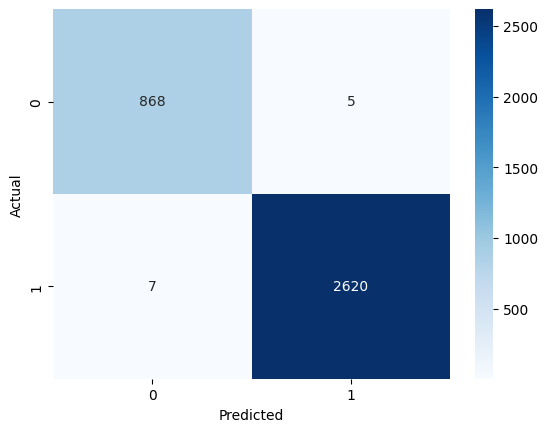

In [24]:
conf_matrix = confusion_matrix(y_val, preds_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Prepare Test Dataset

In [45]:
test_images = glob.glob(test_path+'/*.jpg')

In [46]:
x_test = []

for path in test_images:
    img = load_img(path)  
    img_array = img_to_array(img)
    x_test.append(img_array)

x_test = np.array(x_test)

In [47]:
pred_probs = model.predict(x_test)
y_pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [48]:
image_names = [os.path.basename(p) for p in test_images]

df_submission = pd.DataFrame({
    'id': image_names,
    'has_cactus': y_pred_labels
})

df_submission.to_csv('submission.csv', index=False)